<a href="https://colab.research.google.com/github/cmartinezUCSC/RepositorioSomos_/blob/main/Cuaderno_fastext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

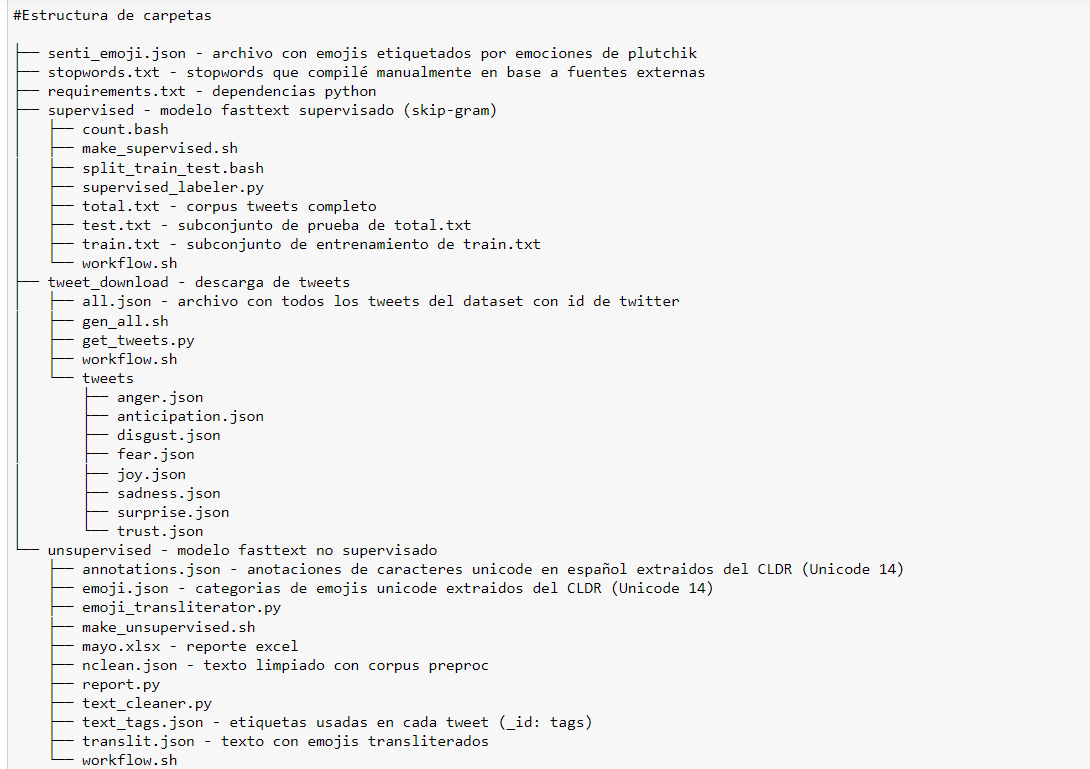

Paso 1: Desde la carpeta Tweets

Name: Get_Tweets.ppp
Outputs: all.json


In [ ]:
x=10
print("Hola mundo ", x)

In [ ]:
##Name: Get_Tweets.py
#@outputs: all.json

import os
import sys
import json
import tweepy
from datetime import datetime

options = " ".join(
    [
        "-is:retweet",
        # '-is:reply',
        # '-is:quote',
        # '-has:hashtags',
        # '-has:links',
        # '-has:mentions',
        # '-has:media',
        "lang:es",
    ]
)

if not "TWITTER_BEARER_TOKEN" in os.environ:
    print(
        "ERROR: Please export twitter bearer token \
in TWITTER_BEARER_TOKEN environment variable",
        file=sys.stderr,
    )
    exit(-1)

api = tweepy.Client(
    bearer_token=os.environ["TWITTER_BEARER_TOKEN"], wait_on_rate_limit=True
)


def search(query):
    query = f"({query}) {options}"
    print(query)
    return tweepy.Paginator(
        api.search_recent_tweets, query=query, max_results=100
    ).flatten(limit=10_000)


with open(sys.argv[1]) as jsonIO:
    emotion_emojis_dict = json.load(jsonIO)

for emotion, emojis in emotion_emojis_dict.items():
    with open(f"tweets/{emotion}.json", "w") as jsonIO:
        query = " OR ".join(emojis)
        json_data = {
            "date": str(datetime.utcnow()).rsplit(".")[0],
            "tweets": [(data.id, data.text) for data in search(query)],
        }
        json.dump(json_data, jsonIO)

In [ ]:
#Name: workflow.sh 
#Descripción: Batch para ejecutar get_tweets.py and gen_all.sh

#!/bin/sh
set -x
# Debe ingresar su bearer token para la API de twitter
TWITTER_BEARER_TOKEN="TWITTER_BEARER_TOKEN"
export TWITTER_BEARER_TOKEN
# Descarga tweets
python3 get_tweets.py
# Compila tweets en archivo all.json
sh gen_all.sh

In [ ]:
#Name: gen_all.sh
#Descripción: Agrega ID a los tweets 
#all.json ID + Tweets  

#!/bin/sh
jq -r '.tweets | map({"_id": first, "text": last})' tweets/* | jq -s 'add'

In [ ]:

#Para saber si los códigos raros de los tweets eran emojies, se usa nosupervisado/emoji.json si se encuentra 
#se reemplaza por el UNICODE de lo contrario usa <unk> (que se limpiará después)


In [ ]:
#UNSUPERVISED
#Name:unsupervised/workflow.sh

#!/bin/sh
set -x
# Translitera emojis a etiquetas
python3 emoji_transliterator.py
# Limpia texto con emojis transliterados
python3 text_cleaner.py
# Genera reporte mayo (se llama así porque se hizo el mes de mayo)
python3 report.py
# Crea modelo no supervisado (skip-gram)
sh make_unsupervised.sh

#Name: emoji_transliterator.py
#Busca Los emojies desde y los reemplaza con el 
#Entradas: emoji.son, annotation.json
#Salidas: text_tags.json, 

#!/usr/bin/env python3
import json
from sys import stderr
from tqdm import tqdm
from unicodedata import normalize
from collections import defaultdict

with open('emoji.json') as io:
    emojis = json.load(io)['Fully_Qualified']
    emojis = sorted(emojis, key=len, reverse=True)

with open('annotations.json') as io:
    annotations = {}
    tmp = json.load(io)
    annotations.update(tmp['Basic'])
    annotations.update(tmp['Derived'])


unannotated = set()
untagged = set()
tag_dict = defaultdict(list)

#Este paso debiera pasar
def replace_emoji(sent, index=0):
    line = sent['text']
    line = normalize('NFC', line)
    for emoji in emojis:
        if emoji in line and emoji in annotations:
            tags = [a for a in annotations[emoji]["tags"] if ' ' not in a]
            if tags:
                line = line.replace(emoji, f' {tags[index]} ')
                tag_dict[sent['_id']].append(tags[index])
                #Buscar en el archivo sentic_emoji.json
            else:
                untagged.add(emoji)
        else:
            unannotated.add(emoji)
    return line


if __name__ == '__main__':
    sents = "../tweet_download/all.json"
    output = "translit.json"
    print(f'reading sentences from {sents}', file=stderr)
    new_sentences = []
    with open(sents, 'r') as io:
        for sent in tqdm(json.load(io)):
            ns = replace_emoji(sent)
            new_sentences.append({'_id': sent['_id'], 'text': ns})
    with open(output, 'w') as io:
        json.dump(new_sentences, io)
    with open('text_tags.json', 'w') as io:
        json.dump(tag_dict, io)
    print(f'untagged: {untagged}')
    print(f'unannotated: {unannotated}')



In [ ]:
#Paso 3
#Name: Emoji_transliterator.py
#Descripción: Se identifica el UNICODE y reemplaza el emoticon por la palabra más frecuente que de la lista 
#@Inputs: emoji.json, annotations.json
#@outputs: text_tags.json, translit.json

import json
from sys import stderr
from tqdm import tqdm
from unicodedata import normalize
from collections import defaultdict

with open('emoji.json') as io:
    emojis = json.load(io)['Fully_Qualified']
    emojis = sorted(emojis, key=len, reverse=True)

with open('annotations.json') as io:
    annotations = {}
    tmp = json.load(io)
    annotations.update(tmp['Basic'])
    annotations.update(tmp['Derived'])


unannotated = set()
untagged = set()
tag_dict = defaultdict(list)

#Este paso debiera pasar
def replace_emoji(sent, index=0):
    line = sent['text']
    line = normalize('NFC', line)
    for emoji in emojis:
        if emoji in line and emoji in annotations:
            tags = [a for a in annotations[emoji]["tags"] if ' ' not in a]
            if tags:
                line = line.replace(emoji, f' {tags[index]} ')
                tag_dict[sent['_id']].append(tags[index])
                #Buscar en el archivo sentic_emoji.json
            else:
                untagged.add(emoji)
        else:
            unannotated.add(emoji)
    return line


if __name__ == '__main__':
    sents = "../tweet_download/all.json"
    output = "translit.json"
    print(f'reading sentences from {sents}', file=stderr)
    new_sentences = []
    with open(sents, 'r') as io:
        for sent in tqdm(json.load(io)):
            ns = replace_emoji(sent)
            new_sentences.append({'_id': sent['_id'], 'text': ns})
    with open(output, 'w') as io:
        json.dump(new_sentences, io)
    with open('text_tags.json', 'w') as io:
        json.dump(tag_dict, io)
    print(f'untagged: {untagged}')
    print(f'unannotated: {unannotated}')


In [ ]:
#Name: text_cleaner.py
#Descripción: limpia texto
#Entradas: translit.json  (con unicode)
#SAlidas: nclean.json (sin unicode y con la palabra repetida)

#!/usr/bin/env python3
import json
import requests
from tqdm import tqdm

session = requests.Session()


def clean_text(text):
    files = {
        "data": (None, text, "text/plain"),
    }
    response = session.post("http://127.0.0.1:8000/preproc", files=files)
    return response.text


with open("translit.json") as tweetsIO:
    tweet_list = json.load(tweetsIO)

tweets = []

for sent in tqdm(tweet_list):
    tweet = sent["text"]
    tweet = tweet.strip()
    tweet = clean_text(tweet).strip()
    tweet = " ".join(tweet.split("\n"))
    if len(tweet):
        tweets.append({"_id": sent["_id"], "text": tweet})

with open("nclean.json", "w") as io:
    json.dump(tweets, io)


In [7]:
#Paso 4:
#Para saber si los códigos raros de los tweets eran emojies, se usa nosupervisado/emoji.json si se encuentra 
#se reemplaza por el UNICODE de lo contrario usa <unk> (que se limpiará después)